<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [11]</a>'.</span>

<img src="../img/iEEG_data_release_header.svg" width=1400 />

# Single subject report
Welcome to the single subject report Notebook! This notebook pre-process the data of a given subject and provides a report about different aspects of the data to assess the quality of the data. This was created for internal validations of the BIDS conversion for data release of the COGITATE but can be used for any other purposes. 

Specifically, this notebook preprocesses the BIDS converted data and computes single channel onset responsiveness. Single electrodes are plotted on the pial surface to assess the validity of the electrodes reconstruction and the single channel activation are plotted to assess data quality. 

<div class="alert alert-info"><h4>Note</h4><p> 
    This notebook does not aim to replicate the analysis of the COGITATE consortium analyses but rather guide users to use our data. The code to replicate the results will be shared <a href="url">here</a>.
</p></div>

In [1]:
# Authors: Alex Lepauvre <alex.lepauvre@gmail.com>
#
# License: MIT-License

In [2]:
# Loading all modules:
import os
from pathlib import Path
import mne
import json
from mne.viz import plot_alignment, snapshot_brain_montage
from mne_bids import BIDSPath, read_raw_bids
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from pingouin import ttest

from cog_ieeg.Preprocessing import preprocessing
from cog_ieeg.OnsetResponsiveness import onset_responsiveness
from cog_ieeg.Decoding import decoding
from cog_ieeg.HelperFunctions import get_roi_channels, create_montage, get_cmap_rgb_values, plot_ieeg_image

import environment_variables as ev


## Set up and download of the BIDS converted data
The first step is to setup your configuration, so that the data are download in the right places. To do this, you should open the file environment_variable.py. There is really only one variable you need to change, called bids_root. This specifies where the data will be downloaded and all the results of the various scripts will be stored. You should see it displayed in the cell below if you set things right:

In [3]:
print("The following path are specified")
print("bids root: ")
print("   {}".format(ev.bids_root))
print("freesurfer directory: ")
print("   {}".format(ev.fs_directory))

The following path are specified
bids root: 
   C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids
freesurfer directory: 
   C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\derivatives\fs


We can now specify the data we want to work with. We are working on the bids converted data, so we just need to specify the name of the subject, the session that we are interested in (there was only 1 in our experiment), the type of data (so ieeg in our case) and the task (we are working on the Dur task of the cogitate project). You don't even need to download the data yourself, it will all be taken care off automatically. The script will ask you for your user name and password though. If you don't have them, you need to first create an account [here](https://www.arc-cogitate.com/data-release) and agree to our terms and conditions

In [4]:
# Specify the subjects to work with:
subject = "CF102"
# Further specify the data to use from the subjects:
session = "1"
datatype = "ieeg"
task = "Dur"

In [5]:
# Parameters
subject = "CF102"


As the data are organized according to the BIDS specification, we can use the mne bids functionalities to load the data:

Extracting parameters from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-CF102\ses-1\ieeg\sub-CF102_ses-1_task-Dur_ieeg.vhdr...


Setting channel info structure...


Reading events from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-CF102\ses-1\ieeg\sub-CF102_ses-1_task-Dur_events.tsv.


Reading channel info from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-CF102\ses-1\ieeg\sub-CF102_ses-1_task-Dur_channels.tsv.


Reading electrode coords from C:\Users\alexander.lepauvre\Documents\GitHub\iEEG-data-release\bids\sub-CF102\ses-1\ieeg\sub-CF102_ses-1_space-fsaverage_electrodes.tsv.


<Info | 11 non-empty values
 bads: []
 ch_names: G1, G2, G3, G4, G5, G6, G7, G8, G9, G10, G11, G12, G13, G14, ...
 chs: 110 ECoG, 24 sEEG, 2 ECG
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dig: 134 items (134 EEG)
 experimenter: mne_anonymize
 highpass: 0.0 Hz
 lowpass: 1024.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 136
 projs: []
 sfreq: 2048.0 Hz
 subject_info: 8 items (dict)
>


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_21232\3377722086.py:4: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['G33', 'EKG1', 'EKG2']
  raw = read_raw_bids(bids_path=bids_path, verbose=True);
C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_21232\3377722086.py:4: RuntimeWarning: Not setting positions of 2 ecg channels found in montage:
['EKG1', 'EKG2']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path=bids_path, verbose=True);


C:\Users\alexander.lepauvre\AppData\Local\Temp\ipykernel_21232\3377722086.py:7: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw.plot_psd()


C:\Users\alexander.lepauvre\AppData\Local\miniconda3\envs\cog_ieeg_release\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


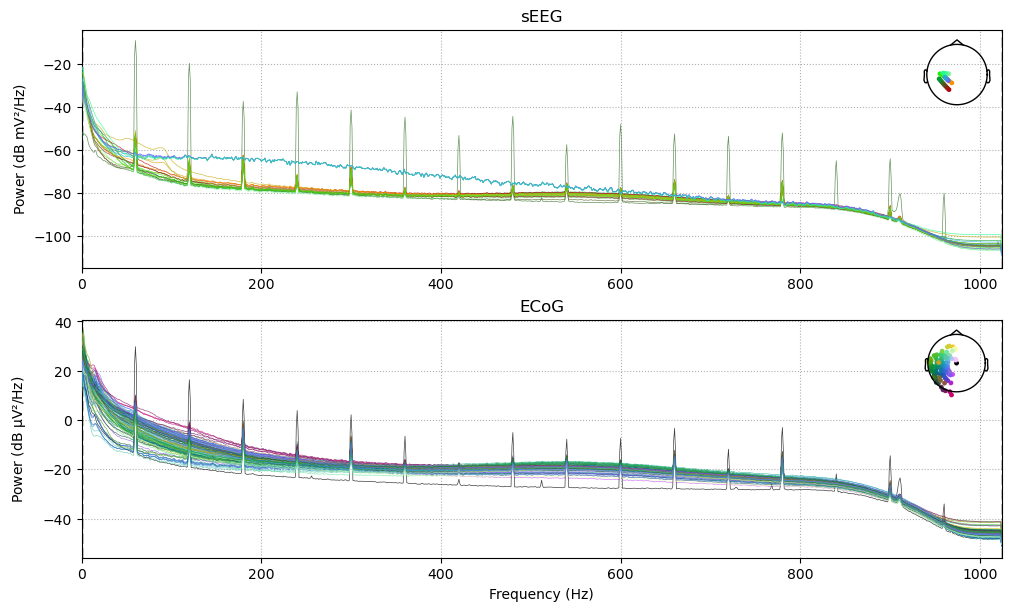

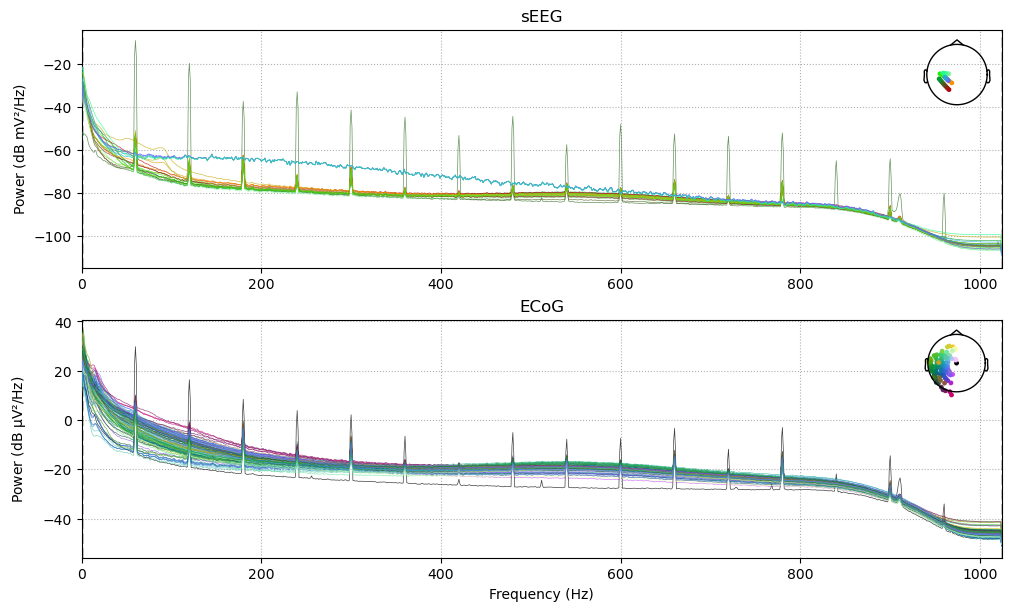

In [6]:
# Create the mne bids path object, making access to the data easier. We will use one example subject to demonstrate the details of our analyses. 
bids_path = BIDSPath(root=ev.bids_root, subject=subject, session=session, datatype=datatype, task=task)
# Loading the raw data
raw = read_raw_bids(bids_path=bids_path, verbose=True);
print(raw.info)
# Plot the power spectrum density of the raw data:
raw.plot_psd()

## Running the preprocessing
The BIDS downloaded data can then be preprocessed. The various pipelines in this notebook have many parameters. Default parameters are stored in json files alongside extensive documentation for each option. The default parameters for the preprocessing apply the following steps to the data:
- Removal of bad channels 
- Notch filtering to remove line noise (60Hz)
- Re-referencing using Laplace scheme
- High gamma computations (70-150Hz)
- ERP computations (0-30Hz)
- Epoching

The preprocessing pipeline take as input either the path to the parameter json file or a dictionary specifying the processing options. Have a look at the ieeg-data-release.ipynb for a description of how the parameters should be adjusted.

For the purpose of this notebook, we will preprocess the data of the specified subject according to the default parameters used in the COGITATE study. 

In [7]:
%%capture
# Loading the parameters:
preprocessing_config = Path(Path(os.path.abspath(".")).resolve().parent, "configs", "preprocessing_config-default.json")
with open(preprocessing_config) as f:
    param = json.load(f)
param["check_plots"] = False
param["plot_single_channels"] = False
preprocessing(param, subject)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\alexander.lepauvre\\Documents\\GitHub\\configs\\preprocessing_config-default.json'

Now that the preprocessing has been applied to the data, we can load the epochs data. The data are stored according to a particular structure, see ieeg-data-release.ipynb for more details. We will plot the power spectrum density to check whether the line noise was indeed removed as well as the channels localization on the brain to ensure that the electrode reconstruction is correct

In [8]:
# Create path to the epochs object:
epochs_path = Path(ev.bids_root, 'derivatives', 'preprocessing',
                   'sub-' + subject, 'ses-' + session, 'ieeg',
                   "epoching", 'high_gamma',
                   "sub-{}_ses-{}_task-{}_desc-epoching_{}-epo.fif".format(subject,
                                                                           session, task,
                                                                           "ieeg"))
# Load the epochs file:
epochs = mne.read_epochs(epochs_path, preload=True)
# There is a bug from MNE such that the montage coordinate space is ignore and considered to be head always.
# Setting the montage to the correct coordinates frame:
from mne.io.constants import FIFF
for d in epochs.info["dig"]:
    d['coord_frame'] = FIFF.FIFFV_MNE_COORD_MNI_TAL

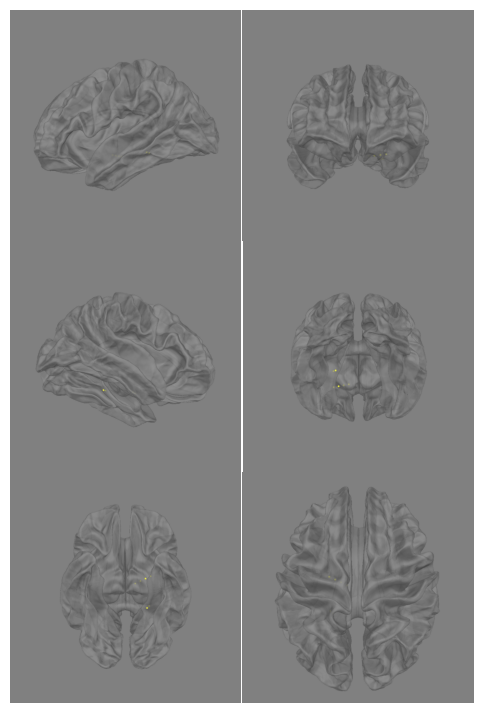

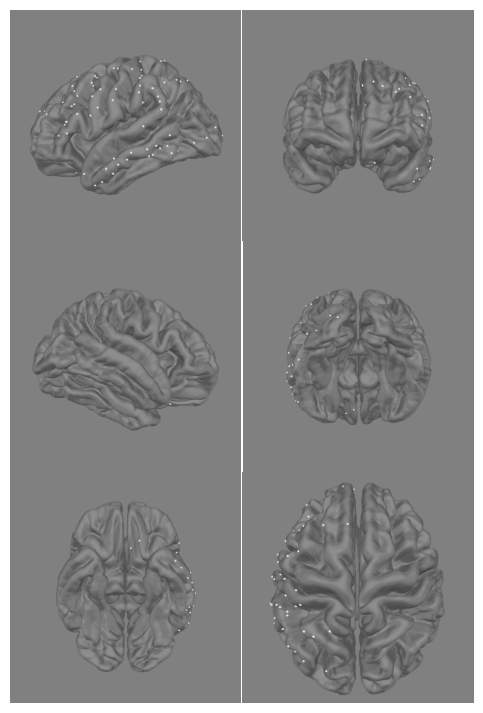

In [9]:
# Plotting channels on the brain:

# Specifying the different views:
orientations = {
    "left": {"azimuth": 180, "elevation": None, "distance": 0.4, "focalpoint": "auto"},
    "front": {"azimuth": 90, "elevation": None, "distance": 0.4, "focalpoint": "auto"},
    "right": {"azimuth": 0, "elevation": None, "distance": 0.4, "focalpoint": "auto"},
    "back": {"azimuth": -90, "elevation": None, "distance": 0.4, "focalpoint": "auto"},
    "top": {"azimuth": 0, "elevation": 180, "distance": 0.4, "focalpoint": "auto"},
    "bottom": {"azimuth": 180, "elevation": 0, "distance": 0.4, "focalpoint": "auto"}
}

# Add the fiducials:
montage = epochs.get_montage()
montage.add_mni_fiducials(ev.fs_directory)
trans = 'fsaverage'
epochs.set_montage(montage, on_missing="warn")

# Plot the ecog and seeg channels separately:
channels_types = [ch_type for ch_type in list(set(epochs.get_channel_types())) if ch_type in ['ecog', 'seeg']]
for ch_type in channels_types:
    epochs_type = epochs.copy().pick(ch_type)
    if ch_type == "ecog":
        fig = plot_alignment(epochs_type.info, subject='fsaverage', subjects_dir=ev.fs_directory,
                             surfaces=['pial'], coord_frame='head', trans=trans)
    else:
        fig = plot_alignment(epochs_type.info, subject='fsaverage', subjects_dir=ev.fs_directory,
                             surfaces=['white'], coord_frame='head', trans=trans)

    # Plot the channels in different orientations:
    fig_2, ax = plt.subplots(3, 2, figsize=(6, 9))
    ax_flat = ax.flatten()
    for i, ori in enumerate(orientations.values()):
        mne.viz.set_3d_view(fig, **ori)
        xy, im = snapshot_brain_montage(fig, epochs_type.info, hide_sensors=False)
        ax_flat[i].imshow(im)
        ax_flat[i].set_axis_off()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()
    mne.viz.close_3d_figure(fig)


## Onset responsiveness pipeline
In order to assess the data quality, we will now run the onset responsiveness pipeline. This pipeline identifies channels for which the activation significantly changes from baseline when a stimulus is being presented. 

In [10]:
%%capture
on_resp_config = Path(Path(os.path.abspath(".")).resolve().parent, "configs", "onset_responsiveness_config-default.json")
results = onset_responsiveness(on_resp_config, subject, plot_single_channels=False, plot_only_responsive=False)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\alexander.lepauvre\\Documents\\GitHub\\configs\\onset_responsiveness_config-default.json'

We can now plot several examples of channels showing an increase in activation

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [11]:
%matplotlib inline
# Extract the 10 most responsive channels:
responsive_channels = results[results['reject'] == True].sort_values(by='f_size', ascending=False, key=abs)
if responsive_channels.shape[0] >= 10:
    responsive_channels = responsive_channels[:10]

# Plot the images of each channel:
for channel in responsive_channels["channel"].to_list():
    plot_ieeg_image(epochs['stimulus onset'], channel.split('-')[1], show=False, 
                    units="HGP (norm.)", scalings=1, cmap="RdYlBu_r",
                    center=None, ylim_prctile=None, logistic_cmap=True, ci=0.95)
    plt.show()

NameError: name 'results' is not defined

We can further plot the responsive channels on the brain surface according to effect size:

In [ ]:
# Extract the responsive channels:
resp_channels = results[results['reject'] == True]
resp_ch_list = [ch.split('-')[1] for ch in resp_channels["channel"].to_list()]

# Extract the responsive channels from the epochs object:
epochs_resp = epochs.copy().pick(resp_ch_list)
# Extract the responsive channels types:
resp_ch_types = [ch_type for ch_type in list(set(epochs_resp.get_channel_types())) if ch_type in ['ecog', 'seeg']]

# Loop through each channel types:
for ch_type in resp_ch_types:
    epochs_type = epochs_resp.copy().pick(ch_type)
    # Extract the channels colors:
    fsizes = []
    for ch in epochs_type.info['ch_names']:
        fsizes.append(resp_channels.loc[resp_channels['channel'] == '-'.join([subject, ch]), 'f_size'].to_list()[0])
    if all([f > 0 for f in fsizes]) or all([f < 0 for f in fsizes]):
        center = None
    else:
        center = 0
    if len(fsizes) > 1:
        ch_colors =  get_cmap_rgb_values(fsizes, center=center)
    else:
        ch_colors = [[1, 0, 0]] * len(fsizes)
    # Plot the surfaces:    
    if ch_type == "ecog":
        fig = plot_alignment(epochs_type.info, subject='fsaverage', subjects_dir=ev.fs_directory,
                             surfaces=dict(pial=0.8), coord_frame='head', trans=trans, sensor_colors=ch_colors)
    else:
        fig = plot_alignment(epochs_type.info, subject='fsaverage', subjects_dir=ev.fs_directory,
                             surfaces=dict(white=0.5), coord_frame='head', trans=trans, sensor_colors=ch_colors)

    fig_2, ax = plt.subplots(3, 2, figsize=(6, 9))
    ax_flat = ax.flatten()
    # Plot the images:
    for i, ori in enumerate(orientations.values()):
        mne.viz.set_3d_view(fig, **ori)
        xy, im = snapshot_brain_montage(fig, epochs_type.info, hide_sensors=False)
        ax_flat[i].imshow(im)
        ax_flat[i].set_axis_off()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    plt.close()
    mne.viz.close_3d_figure(fig)

# Acknowledgments
This notebook is brought to you by the intracranial team of the COGITATE consortium.
<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
   <div style="text-align: center;">
      <a href="https://www.arc-cogitate.com/our-team" target="_blank">
         <img src="../img/IEEG TEAM.png" alt="iEEG team">
      </a>
   </div>
</div>
<br />
We would like to thank all the COGITATE consortium members:
<div style="display: flex; flex-wrap: wrap; justify-content: space-around;">
   <div style="text-align: center;">
      <a href="https://www.arc-cogitate.com/our-team" target="_blank">
         <img src="../img/IEEG DP Authors.png" alt="COGITATE team">
      </a>
   </div>
</div>
<img style="float: right;" src="../img/templeton_logo.png" width=200;>
<br />
<br />

This research was supported by Templeton World Charity Foundation ([TWCF0389](https://doi.org/10.54224/20389)) and the Max Planck Society. The opinions expressed in this publication are those of the authors and do not necessarily reflect the views of TWCF.
